In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


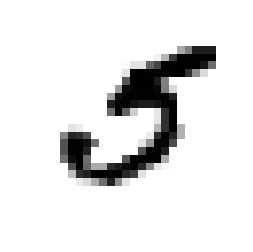

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")


plt.show()

In [6]:
y[36000]

5

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
# Own cross validation
# In case I need more control over the cross validation stage

from sklearn.model_selection import StratifiedKFold # folds with stratified sampling
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9502
0.96565
0.96495


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5,cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

In [16]:
# Really dumb classifier
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

    
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [17]:
# Confussion matrix = how many times the predictor got confused and clssified somehting as something that It wast
# First predictions with the training set

from sklearn.model_selection import cross_val_predict
# Get predictions
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

#Each row in a confusion matrix represents an actual class, while each column repre‐
#sents a predicted class. 
# first row is the negatice class

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

In [18]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))
#  Remember that we stay with the training set until the laaaaaaast minute

0.7687135020350381
0.801328168234643


In [20]:
# combined score for precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [21]:
y_scores= sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [23]:
threshold=0
y_some_digit_pred= (y_scores> threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold=200000
y_some_digit_pred= (y_scores> threshold)
y_some_digit_pred

array([False])

So how can you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores

In [26]:
y_scores= cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

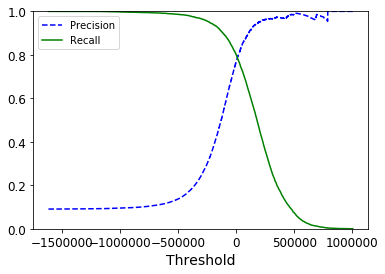

In [28]:
# recall precision curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds, recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

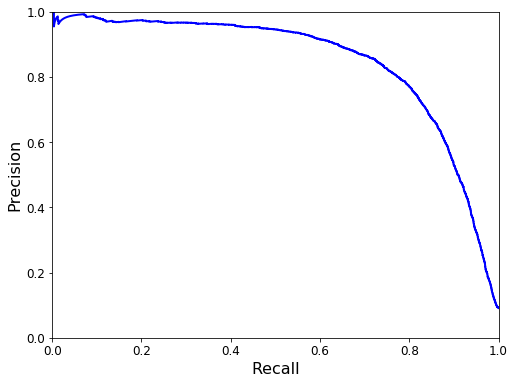

In [30]:

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

In [31]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5,y_train_pred_90)


0.8659205116491548

In [32]:
recall_score(y_train_5,y_train_pred_90)

0.6993174691016417

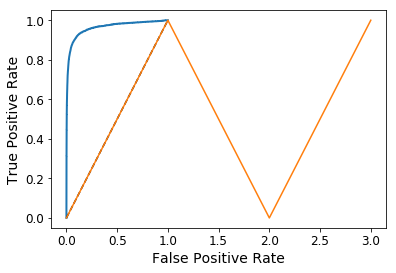

In [33]:
from sklearn.metrics import roc_curve

fpr,tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.plot([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr,tpr)
plt.show()
    

In [34]:
#A per‐fect classifier will have a ROC AUC equal to 1,
#whereas a purely random classifier will have a ROC AUC equal to 0.5. 
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967156

In [35]:
# now lets try a random forest classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest= cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")


c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [36]:
y_scores_forest = y_probas_forest[:,1] #score probe of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	lower left
	best
	center
	lower center
	center left
	upper right
	upper center
	center right
	lower right
	right
	upper left

  % (loc, '\n\t'.join(self.codes)))


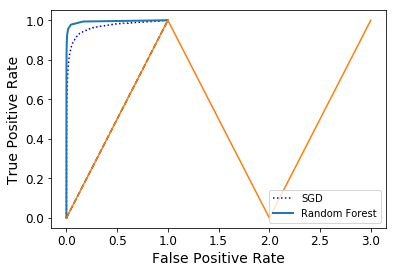

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

# Multiclass Classification

In [38]:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))


[5]


In [40]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
sgd_clf.classes_

[[-311402.62954431 -363517.28355739 -446449.5306454  -183226.61023518
  -414337.15339485  161855.74572176 -452576.39616343 -471957.14962573
  -518542.33997148 -536774.63961222]]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [42]:
# To force one s one or one vs all
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameter

c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameter

c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\pc42630\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameter

array([5], dtype=int8)

In [43]:
len(ovo_clf.estimators_)

45

In [45]:
# Now a random Forest
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [46]:
forest_clf.predict_proba([some_digit]) # probabilities for each class

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [50]:
# accuracy can encreacy by scalingg the inputs
# not quite sure what its to incerase in this case but ok
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

In [52]:
# confusion matrix based on cross validation for several cathegories

y_train_pred= cross_val_predict(sgd_clf,X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

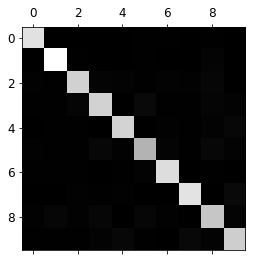

In [58]:
# That was confusing... another way to see it is

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [59]:
row_sums= conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

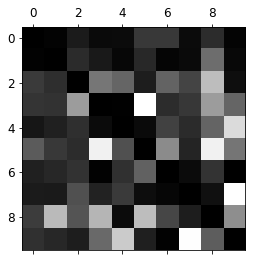

In [61]:
# fill diagonal with 0 so that we keep only errors

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [63]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

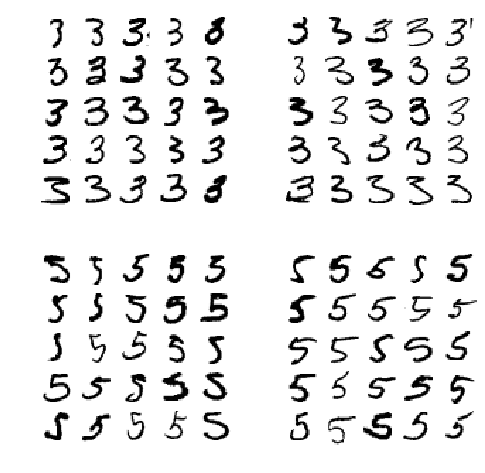

In [64]:
cl_a, cl_b= 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab= X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba= X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb= X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [65]:
# Multilable classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 ==1)
y_multilabel= np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [67]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_train,cv=3, n_jobs=-1)
f1_score(y_train,y_train_knn_pred,average="macro")

0.9684554018028022

In [73]:

noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test + noise
y_train_mod = X_train
y_test_mod = X_test


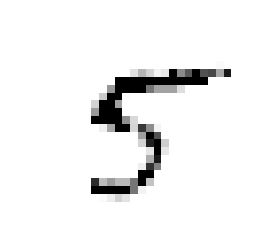

In [77]:
some_index = 5500
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)
